In [33]:
import Utils
import Data.Tuple.Extra (uncurry3)
import Data.Bool (bool)
import Data.List (sortOn)
import Data.Ord (Down(..))
import Data.Function (on, (&))
import Data.Maybe (fromJust)
import Control.Monad.Trans.Class (lift)

In [34]:
import Tyche.Model
import Tyche.Dist
import Tyche.Prelude
import Tyche.Prob
import Tyche.Inference.Enumerate

In [35]:
import Graphics.Vega.VegaLite hiding (filter, lookup, repeat, FontWeight(Normal))
import qualified Graphics.Vega.VegaLite as VL (filter, lookup, repeat, FontWeight(Normal))

In [36]:
data World = World {label :: String, price :: Double} deriving Eq

instance Ord World where
  w <= w' = price w <= price w'

instance Show World where
  show (World l _) = l
  
type Prop = [World]

prices = [(2,0.05), (6,0.10), (10,0.15), (14,0.20), (18,0.20), (22,0.15), (26,0.10), (30,0.05)]
universe = [World ("w" ++ show i) i | (i,_) <- prices]

In [37]:
worldPrior :: Model World
worldPrior = do
  w <- unif universe
  weight . log . fromJust $ lookup (price w) prices 
  return w

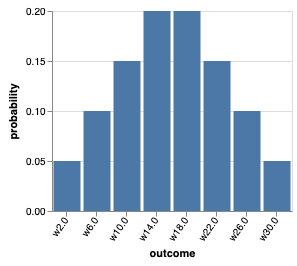

In [38]:
vlShow . barFromDist <$> enumD worldPrior

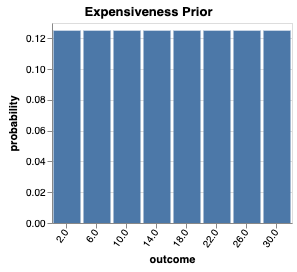

In [39]:
thresholdPrior :: Model Double
thresholdPrior = unif [price w | w <- universe]

vlShow . titled "Expensiveness Prior" . barFromDist <$> enumD thresholdPrior

In [40]:
alpha :: Double
alpha = 4

data Utt = UMum | UExp -- | UChp
  deriving (Eq, Show, Ord, Enum, Bounded)

utterances = [minBound .. maxBound]

cost :: Utt -> Double
cost UMum = 0
cost UExp = 1
-- cost UChp = 1

utterancePrior :: Model Utt
utterancePrior = belief . fromList $ [(u, - alpha * cost u) | u <- utterances]

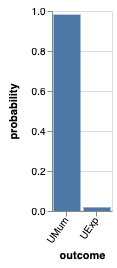

In [42]:
vlShow . barFromDist <$> enumD utterancePrior

In [43]:
den :: Utt -> Double -> Prop
den UMum _ = universe
den UExp d = filter ((>= d) . price) universe
-- den UChp (tl,sh) = filter ((<= sh) . price) universe

In [44]:
literal :: Utt -> Double -> Model (World, Double)
literal u d = do
  w <- worldPrior
  condition (w `elem` den u d)
  return (w, d)

Even a literal listener ought to be somewhat evaluative!

> "Expensive"

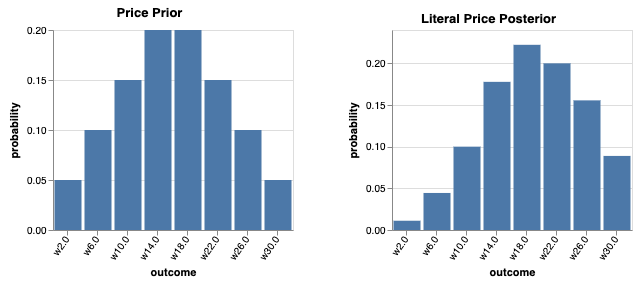

In [46]:
vlShow . sidewaysDists <$> sequence
  [ titled "Price Prior" . barFromDist <$> enumD worldPrior
  , titled "Literal Price Posterior" . barFromDist <$> enumD (thresholdPrior >>= fmap fst . literal UExp)
  ] 

In [47]:
speaker1 :: World -> Double -> Model Utt
speaker1 w d = do
  u <- utterancePrior
  lnr <- lift . enumD $ fst <$> literal u d
  weight $ alpha * logProb lnr w
  return u

In [48]:
listener1 :: Utt -> Double -> Model (World, Double)
listener1 u _ = do
  w <- worldPrior
  d <- thresholdPrior
  spr <- lift . enumD $ speaker1 w d
  observe spr u
  return (w,d)

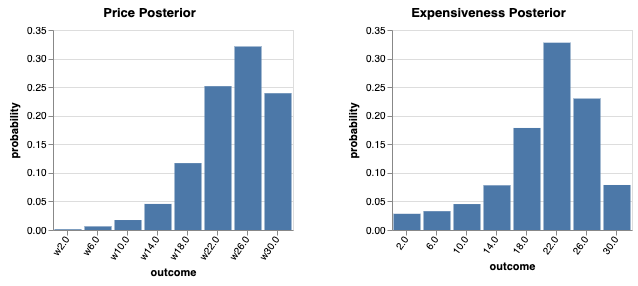

In [49]:
vlShow . sidewaysDists <$> sequence
  [ titled "Price Posterior"         . barFromDist <$> enumD (fst <$> listener1 UExp 2)
  , titled "Expensiveness Posterior" . barFromDist <$> enumD (snd <$> listener1 UExp 2)
  -- , titled "Cheapness Posterior"     . barFromDist <$> enumD (snd . snd <$> listener UExp)
  ]

In [17]:
{--
vlShow . sidewaysDists $
  [ titled "Price Posterior"         . barFromDist $ enumD (fst <$> listener UChp)
  , titled "Expensiveness Posterior" . barFromDist $ enumD (fst . snd <$> listener UChp)
  , titled "Cheapness Posterior"     . barFromDist $ enumD (snd . snd <$> listener UChp)
  ]
--}

In [50]:
speaker2 :: World -> Double -> Model Utt
speaker2 w d = do
  u <- utterancePrior
  lnr <- lift . enumD $ fst <$> listener1 u d
  weight $ alpha * logProb lnr w
  return u

In [51]:
listener2 :: Utt -> Double -> Model (World, Double)
listener2 u d = do
  w <- worldPrior
  spr <- lift . enumD $ speaker2 w d
  observe spr u
  return (w,d)

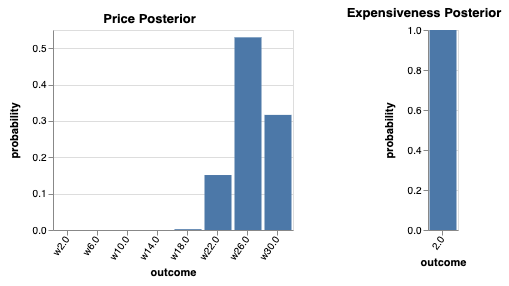

In [52]:
vlShow . sidewaysDists <$> sequence
  [ titled "Price Posterior"         . barFromDist <$> enumD (fst <$> listener2 UExp 2)
  , titled "Expensiveness Posterior" . barFromDist <$> enumD (snd <$> listener2 UExp 2)
  -- , titled "Cheapness Posterior"     . barFromDist $ enumD (snd . snd <$> listener2 UExp)
  ]

In [53]:
speaker3 :: World -> Double -> Model Utt
speaker3 w d = do
  u <- utterancePrior
  lnr <- lift . enumD $ fst <$> listener2 u d
  weight $ alpha * logProb lnr w
  return u

In [54]:
listener3 :: Utt -> Double -> Model (World, Double)
listener3 u d = do
  w <- worldPrior
  spr <- lift . enumD $ speaker3 w d
  observe spr u
  return (w,d)

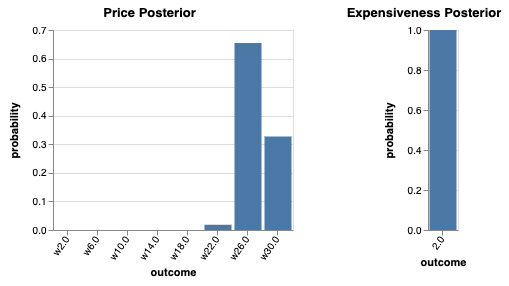

In [55]:
vlShow . sidewaysDists <$> sequence
  [ titled "Price Posterior"         . barFromDist <$> enumD (fst <$> listener3 UExp 2)
  , titled "Expensiveness Posterior" . barFromDist <$> enumD (snd <$> listener3 UExp 2)
  -- , titled "Cheapness Posterior"     . barFromDist $ enumD (snd . snd <$> listener3 UExp)
  ]

In [59]:
listener' :: Int -> Utt -> Double -> Model (World, Double)
listener' n u d = do
  w <- worldPrior
  spr <- lift . enumD $ speaker' n w d
  observe spr u
  return (w,d)

speaker' :: Int -> World -> Double -> Model Utt
speaker' n w d = do
  u <- utterancePrior
  let agent = if n == 1 then literal else listener' (n-1)
  lnr <- lift . enumD $ fst <$> agent u d
  weight $ alpha * logProb lnr w
  return u

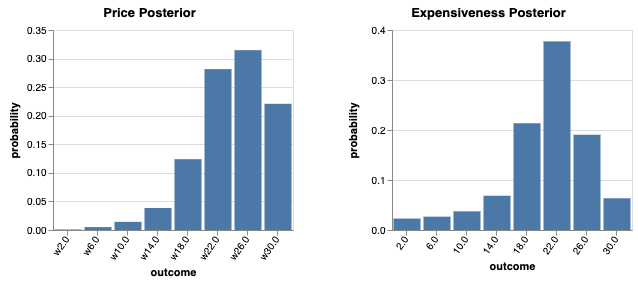

In [68]:
vlShow . sidewaysDists <$> sequence
  [ titled "Price Posterior"         . barFromDist <$> enumD (thresholdPrior >>= fmap fst . listener' 2 UExp)
  , titled "Expensiveness Posterior" . barFromDist <$> enumD (thresholdPrior >>= fmap snd . listener' 2 UExp)
  -- , titled "Cheapness Posterior"     . barFromDist $ enumD (snd . snd <$> listener2 UExp)
  ]

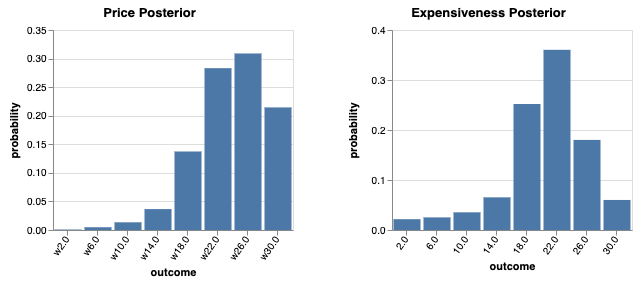

In [69]:
vlShow . sidewaysDists <$> sequence
  [ titled "Price Posterior"         . barFromDist <$> enumD (thresholdPrior >>= fmap fst . listener' 3 UExp)
  , titled "Expensiveness Posterior" . barFromDist <$> enumD (thresholdPrior >>= fmap snd . listener' 3 UExp)
  -- , titled "Cheapness Posterior"     . barFromDist $ enumD (snd . snd <$> listener2 UExp)
  ]